# Tutorial: How to scale and rotate contours in OpenCV

In this tutorial, I'll walk you through how one can scale and rotate a contour.

## TL;DR just want the code

The functions are present in this github gist: https://gist.github.com/nvs-abhilash/75a3920980fe32ffd4754bc205362125.

Follow along, if you want to understand what's the simple idea behind the implementation.

## Why?

Why would one want to scale or rotate a contour of objects in an image? For me, I had a very similar problem as this one: https://answers.opencv.org/question/44580/how-to-resize-a-contour/. 

I had to scale down the output of an Image Segmentation deep learning model for a specific class, to tightly fit the object of that class. Basically a post processing step for my deep learning model.

I am not able to think of any other "generic" applications for this, may be you can comment for which applications you found it useful.

Plus, I did not find any python articles regarding this, so I thought I'll give it a try.

## Learning by example

Throughout this short tutorial, I would be using a simple image to demostrate my points, below is some code for imports and loading the image, and generating the contours. You know, that standard stuff!

In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

# Reading the image
im = cv2.imread('sample_img.png')

# Converting image to grayscale
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Thresholding and getting contours from the image
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


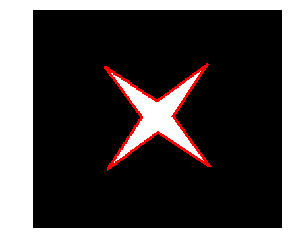

In [2]:
im_copy = im.copy()

cv2.drawContours(im_copy, contours, 0, (255, 0, 0), 3)

plt.imshow(im_copy)
plt.axis("off");

## How to resize contours

Well, the idea is pretty simple, and if you have some understanding of high-school math, below steps would seem very sensible:

* Step 1: Translate the contour to the origin
* Step 2: Scale each point of the contour
* Step 3: Translate back the contour to it's original place.

Below I explain and show code equivalents of each step.

### Translate the contour to the origin

To translate the contour to the origin, we just have to subtract the coordinates of the centroid of the contour with all the points. And the centeroid of the contour can be found using the `cv2.moments` function.

* Getting the centroid of the contour
```python
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
```

* Translating the contour by subtracting the center with all the points
```python
cnt_norm = cnt - [cx, cy]
```

### Scale each point of the contour

* To scale each point of the contour, we just have to multiply the scale with the contour points.

```python
cnt_scaled = cnt_norm * scale
```

### Translate back the contour to it's original place.

* This step can be achieved by simply adding back the centroid co-ordinates to the contour points and that's it!

```python
cnt_scaled = cnt_scaled + [cx, cy]
cnt_scaled = cnt_scaled.astype(np.int32)
```

### Combining all the steps into a function for scaling

Hence we can write a simpe function based on the above steps as below:

In [3]:
def scale_contour(cnt, scale):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

And we can call this function to test that it works fine!

* **RED BOUNDRY**: Original contour
* **GREEN BOUNDRY**: Scaled contour

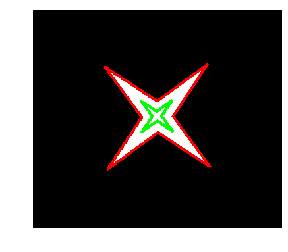

In [4]:
cnt_scaled = scale_contour(contours[0], 0.3)

im_copy = im.copy()
cv2.drawContours(im_copy, contours, 0, (255, 0, 0), 3)
cv2.drawContours(im_copy, [cnt_scaled], 0, (0, 255, 0), 3)

plt.imshow(im_copy)
plt.axis("off");

## How to rotate contours

Rotating contours are also simple, and again would just take some high school math to understand the steps. 

* Step 1: Translate the contour to the origin
* Step 2: Rotate each point of the contour
* Step 3: Translate back the contour to it's original place.

### Translate the contour to the origin

* Getting the center
```python
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
```

* Translating the contour by subtracting the center with all the points
```python
cnt_norm = cnt - [cx, cy]
```

### Rotating each point of the contour

Once you have put the contour to the origin, we have to rotate each point. And for me understanding rotation is much easier in polar co-ordinates as compared to cartesian co-ordinates (I hope for you too :P). So, that's what we'll do! Convert the points to polar coordates, add the rotation, and convert it back to cartesian co-ordinates. 

* These are some helper functions which I borrowed from [here](https://stackoverflow.com/a/26757297) to convert back and forth between polar and cartesian co-ordinates

```python
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho


def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y
```

* Converting the `x-y`(cartesian) co-ordinates to `theta-rho` (polar)
```python
coordinates = cnt_norm[:, 0, :]
xs, ys = coordinates[:, 0], coordinates[:, 1]
thetas, rhos = cart2pol(xs, ys)
```

* Adding the `angle` to the `thetas`. 
```python
thetas_deg = np.rad2deg(thetas)
thetas_new_deg = (thetas_deg + angle) % 360
thetas_new = np.deg2rad(thetas_new_deg)
```

    **Note**: I converted the radians to degrees because I chose to give `angle` in degrees form (and it makes modulo operation much cleaner). Then I again convert it back to radians. 


* Convert the new polar coordinates to cartesian co-ordinates:
```python
xs, ys = pol2cart(thetas, rhos)
cnt_norm[:, 0, 0] = xs
cnt_norm[:, 0, 1] = ys
```

### Translate back the contour to it's original place.

Add center coordinates to the contours' coordinates
```python
cnt_rotated = cnt_norm + [cx, cy]
cnt_rotated = cnt_rotated.astype(np.int32)
```

### Combining all the steps into a function for rotation

Hence we can write a simpe function based on the above steps as below:

In [5]:
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho


def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y


def rotate_contour(cnt, angle):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    
    coordinates = cnt_norm[:, 0, :]
    xs, ys = coordinates[:, 0], coordinates[:, 1]
    thetas, rhos = cart2pol(xs, ys)
    
    thetas = np.rad2deg(thetas)
    thetas = (thetas + angle) % 360
    thetas = np.deg2rad(thetas)
    
    xs, ys = pol2cart(thetas, rhos)
    
    cnt_norm[:, 0, 0] = xs
    cnt_norm[:, 0, 1] = ys

    cnt_rotated = cnt_norm + [cx, cy]
    cnt_rotated = cnt_rotated.astype(np.int32)

    return cnt_rotated

And we can call this function to test that it works fine!

* **RED BOUNDRY**: Original contour
* **GREEN BOUNDRY**: Scaled contour

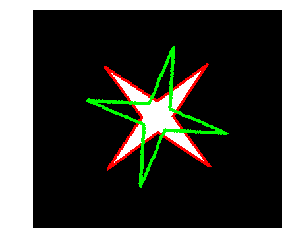

In [6]:
cnt_rotated = rotate_contour(contours[0], 60)

im_copy = im.copy()
cv2.drawContours(im_copy, contours, 0, (255, 0, 0), 3)
cv2.drawContours(im_copy, [cnt_rotated], 0, (0, 255, 0), 3)

plt.imshow(im_copy)
plt.axis("off");

## Having fun with random rotation, scale, and translation

Here is a simple code to generated random rotation, scaling and translation (not covered in the tutorial but it's just a simple addition of co-ordinates).

In-case someone wants to disect this code, these are the key things I did:
* Generate multiple randon contours with a loop. (I know right :D )
* Get randomness with `np.random.random()` which returns random numbers between `[0, 1)`. We can multiply it with desired max value to get values between `[0, max_vale)`.
* For rotation, I chose angle between `0` and `90` degrees, as the image is symmetric at `90` degrees rotation.
* For scale I took random values between `0` to `0.5`, i.e. from 0% to 50% of original contour.
* Randomly translated between `(-200, 200)` across x and y axis.
* Random color generation of rgb values.
* Just drawing the contours with `thickness=-1` which dentes to fill the contour.

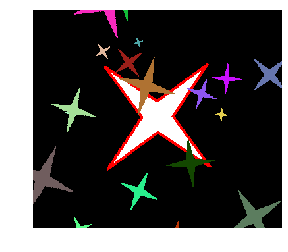

In [8]:
im_copy = im.copy()
cv2.drawContours(im_copy, contours, 0, (255, 0, 0), 3)

for i in range(20):
    cnt_rotated = rotate_contour(contours[0], np.random.random() * 90)
    cnt_scaled = scale_contour(cnt_rotated, np.random.random() * 0.5)
    
    cnt_translated = cnt_scaled + np.random.randint(low=-200, high=200, size=(2,))
    
    r, g, b = [int(np.random.choice(range(255))) for _ in range(3)]
    cv2.drawContours(im_copy, [cnt_translated], 0, (r, g, b), -1)

plt.imshow(im_copy)
plt.axis("off");